# Probabilistic Microsimulation

Playing around with ideas about probabilistic microsimulation

In [1]:
# Initialise

import pymc3 as pm

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import random
import math
import daft

## Define the population

The population is defined by a series of lists; one list for each characteristic of the individuals.

In [51]:
N = 100 # The number of individuals we're going to create
a = np.arange(N) # A list of indixces (0, 1, ..., N)

# All distributions etc. need to be defined within the context of a pymc model
model = pm.Model()

# Age is represented using a poisson distribution with the lambda parameter representing the expected age
# Lambda is randomly drawn from a normal distribution with mean 30 (mean pop age = 30)
pop_ages

# Income is also poisson.
pop_inc = []

# Assume sex is either male or female, so represent with a Bernouilli distribution
pop_sex = []



with model:
    for i in a:
        age = abs(random.gauss(mu=30, sigma=20)) # (make absolute so no one is negative age)
        inc = abs(random.gauss(mu=30, sigma=20)) # (make absolute so no one is negative age)
        pop_age.append( pm.Poisson(name="age"+str(i), mu=age) )
        pop_inc.append( pm.Poisson(name="inc"+str(i), mu=inc) )
        pop_sex.append( pm.Bernoulli(name="sex"+str(i), p=0.5) )

INFO (theano.gof.compilelock): Refreshing lock /Users/nick/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/nick/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock


The population is defined by a series of probability distributions, one for each of the characteristics of the individuals. These are:

  - Age: $A$, which we will model with a Poisson distribution.
  
    $$A \sim \text{Poi}(A_p) $$
  
  Poisson's have a single parameter (usually called $\lambda$). We don't know anything about this parameter, so model it with a uniform distribution between 0-100 called $A_p$.
  
  $$A_p \sim \text{Uni}(0,100) $$
  
  - Income: $I$, is also a Poisson. 
  
  $$I \sim \text{Poi}(I_p) $$
  
  This time though we model it's parameter with another Poisson distribution, $I_p$ so that we can assume that the mean aggregate income of the population is ~£25k. I.e. 
  
  $$I_p \sim \text{Poi}(25) $$

  - Sex: $S$ is assumed to be either male or female for now, so can be simulated with a Bernoulli distribution:
  
  $$S \sim \text{Ber}(S_p) $$
  
  where the parameter, (usually called $p$), can also be represented with a uniform distribution between 0 - 1:
  
  $$S_p \sim \text{Uni}(0,1) $$

Lets display those relationships in a graph using the [daft](http://daft-pgm.org/) library:

(_I don't think I am using the correct symbols on this graph_)

(_Also, those nodes are latent, how to represent the aggregate data (observations)?_)

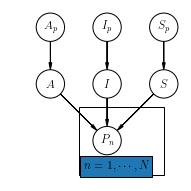

In [54]:
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

pgm = daft.PGM([3.0, 3.0], origin=[0.3, 0.3], observed_style="inner")

# Add the parameters
pgm.add_node(daft.Node("age_param", r"$A_p$", 1.0, 3.0))#, fixed=True))
pgm.add_node(daft.Node("inc_param", r"$I_p$", 2.0, 3.0))#, fixed=True))
pgm.add_node(daft.Node("sex_param", r"$S_p$", 3.0, 3.0))#, fixed=True))

# Add the distribtions
pgm.add_node(daft.Node("age", r"$A$", 1.0, 2.0))
pgm.add_node(daft.Node("inc", r"$I$", 2.0, 2.0))
pgm.add_node(daft.Node("sex", r"$S$", 3.0, 2.0))

# Edges between them
pgm.add_edge("age_param", "age")
pgm.add_edge("inc_param", "inc")
pgm.add_edge("sex_param", "sex")

# The final node (i.e. the actual individual) and edges to it
pgm.add_node(daft.Node("person", r"$P_n$", 2.0, 1.0))
pgm.add_edge("age", "person")
pgm.add_edge("inc", "person")
pgm.add_edge("sex", "person")

pgm.add_plate(daft.Plate([1.5, 0.4, 1.5, 1.2], label=r"$n = 1, \cdots, N$"))


# Render and save.
pgm.render()
#pgm.figure.savefig("nogray.pdf")
#pgm.figure.savefig("nogray.png", dpi=150)

Now define those programatically:

In [5]:
N = 100 # The number of individuals we're going to create
a = np.arange(N) # A list of indixces (0, 1, ..., N)

# All distributions etc. need to be defined within the context of a pymc model
model = pm.Model()

with model:
    # Individual age is represented using a poisson distribution with the lambda parameter representing the 
    # expected age of the person.
    # The lambda parameter is itself represented with a distribution. We don't know anything about it so
    # make it uniform (OK, it could also be Poisson if we have some ideas about the aggregate distributions
    # of the individuals' ages, e.g. if we assume that most people are 30, but keep it uniform for now).
    # We want to find good values for those parameters ... 
    # (shape creates N different distributions; one for each individual)
    pop_age_param = pm.Uniform("age_param", lower=0, upper= 100, shape=N) # Not great if people are older than 100
    pop_age = pm.Poisson("age", mu=pop_age_param, shape=N)

    # Income is also poisson. This time assume that the expected income of an individual is likely to be ~25k
    pop_inc_param = pm.Poisson("inc_param", mu=25, shape=N)
    pop_inc = pm.Poisson("inc", mu=pop_inc_param, shape=N)

    # Assume sex is either male or female, so represent with a Bernouilli distribution. Again, there is a 
    # parameter that we need to estimate an appropriate value for
    pop_sex_param = pm.Uniform("sex_param", lower=0.0, upper=1.0, shape=N)
    pop_sex = pm.Bernoulli("sex", p = pop_sex_param, shape=N)

## Interrogate the (prior) population

Lets have a look at the population priors; before observing any real data.

In [6]:
# Initial values ('test_value')
with model:
    print("Ages: " +    str([ str(pop_age[i].tag.test_value) for i in a ] ) )
    print("Incomes: " + str([ str(pop_inc[i].tag.test_value) for i in a ] ) )
    print("Sexes: " +   str([ str(pop_sex[i].tag.test_value) for i in a ] ) )
#with model:
    #print("Ages: " +    str([ x.tag.test_value for x in pop_age ] ) )
    #print("Incomes: " + str([ x.tag.test_value for x in pop_inc ] ) )
    #print("Sexes: " +   str([ x.tag.test_value for x in pop_sex ] ) )

Ages: ['50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50']
Incomes: ['25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25',

## Model aggregate data

The previous variables are all latent; they cannot be observed directly. Instead, we will have aggregate data that tell us about the underying population. These need to be included in the model as 'observed' nodes (i.e. stochastic variables that have a fixed value).

### Observe aggregate data

Now lets observe some 'real' data (an age, income, sex table) ... 

XXXX